In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
df=pd.read_csv('cricket_shot_selection_updated.csv')

In [61]:
df.head()

,Bowler Type,Ball Length,Ball Line,Speed (km/h),Shot Type,Runs Scored,Wicket,Field Placement,Angle,Bounce (cm),Field Positions
0,Fast,Good,Off-stump,143,Straight Drive,1,0,Defensive,12.186259,59,Mid-wicket
1,Fast,Full,Middle,124,Edge,0,1,Aggressive,-8.558394,110,Mid-wicket
2,Fast,Short,Off-stump,130,Hook,0,0,Aggressive,3.626683,113,Square Leg
3,Fast,Short,Off-stump,144,Edge,0,0,Balanced,-0.303302,49,Square Leg
4,Spin,Good,Off-stump,146,Edge,0,0,Aggressive,14.080987,28,Cover


In [62]:
df.tail()

,Bowler Type,Ball Length,Ball Line,Speed (km/h),Shot Type,Runs Scored,Wicket,Field Placement,Angle,Bounce (cm),Field Positions
9995,Fast,Short,Off-stump,136,Flick,4,0,Aggressive,-6.865793,78,Slips
9996,Fast,Full,Leg-stump,129,Sweep,6,0,Balanced,10.160395,109,Fine Leg
9997,Spin,Good,Middle,116,Edge,6,0,Balanced,1.164965,90,Slips
9998,Fast,Full,Off-stump,145,Defensive,4,0,Defensive,12.773107,94,Fine Leg
9999,Fast,Good,Leg-stump,131,Pull,0,0,Balanced,-1.806062,82,Cover


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Bowler Type      10000 non-null  object 
 1   Ball Length      10000 non-null  object 
 2   Ball Line        10000 non-null  object 
 3   Speed (km/h)     10000 non-null  int64  
 4   Shot Type        10000 non-null  object 
 5   Runs Scored      10000 non-null  int64  
 6   Wicket           10000 non-null  int64  
 7   Field Placement  10000 non-null  object 
 8   Angle            10000 non-null  float64
 9   Bounce (cm)      10000 non-null  int64  
 10  Field Positions  10000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 859.5+ KB


In [64]:
df.columns

Index(['Bowler Type', 'Ball Length', 'Ball Line', 'Speed (km/h)', 'Shot Type',
       'Runs Scored', 'Wicket', 'Field Placement', 'Angle', 'Bounce (cm)',
       'Field Positions'],
      dtype='object')

In [65]:
mass = 0.156      # cricket ball kg
g = 9.81

# conversions
df['speed_mps'] = df['Speed (km/h)'] / 3.6
df['angle_rad'] = np.radians(df['Angle'])

# physics features
df['kinetic_energy'] = 0.5 * mass * df['speed_mps']**2
df['momentum'] = mass * df['speed_mps']

df['vx'] = df['speed_mps'] * np.cos(df['angle_rad'])
df['vy'] = df['speed_mps'] * np.sin(df['angle_rad'])

df['flight_time'] = (2 * df['vy']) / g
df['proj_range'] = df['vx'] * df['flight_time']

<b> RQ1

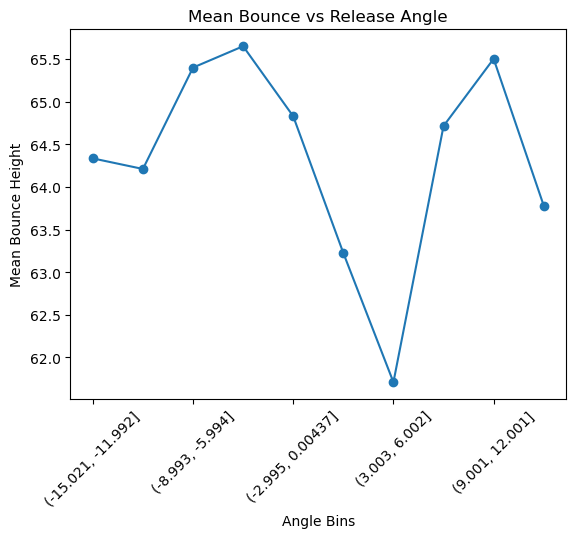

In [66]:
bins = pd.cut(df['Angle'], 10)

trend = (
    df.groupby(bins)['Bounce (cm)']
      .mean()
)

trend.plot(marker='o')

plt.xlabel("Angle Bins")
plt.ylabel("Mean Bounce Height")
plt.title("Mean Bounce vs Release Angle")

plt.xticks(rotation=45)
plt.show()

In [67]:
df['Angle'].corr(df['Bounce (cm)'])

-0.00801331968562731

This showed that there is no linear connection between angle and bounce. This showed that bounce height depends upon pitch hardness, surface friction, speed and seam interaction.

<b> RQ2

In [68]:
energy_stats = (
    df.groupby(pd.qcut(df['kinetic_energy'], 5))
      .agg(
          avg_runs=('Runs Scored','mean'),
          wicket_rate=('Wicket','mean')
      )
)

print(energy_stats)

                    avg_runs  wicket_rate
kinetic_energy                           
(72.823, 83.802]    1.541043     0.050794
(83.802, 95.55]     1.616382     0.055469
(95.55, 108.069]    1.598187     0.050352
(108.069, 121.357]  1.596892     0.052938
(121.357, 133.617]  1.528281     0.048874


Very high energy minimizes runs, slightly lower energy maximizes wickets, and medium energy is most punishable.

<b> RQ3

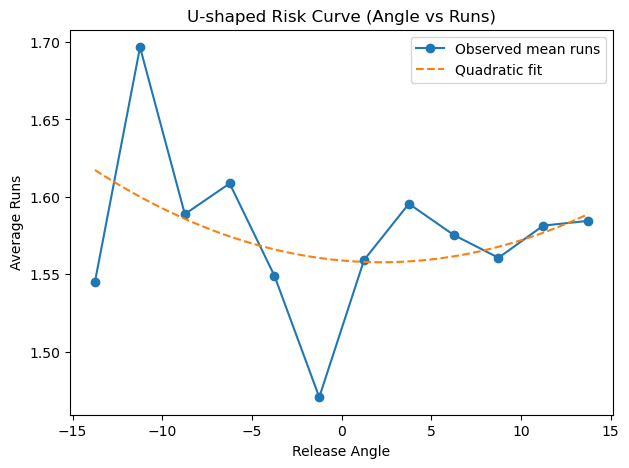

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- bin angle ----
bins = pd.cut(df['Angle'], 12)

trend = (
    df.groupby(bins)['Runs Scored']
      .mean()
      .reset_index()
)

# bin centers for smooth plotting
centers = [b.mid for b in trend['Angle']]

x = np.array(centers)
y = trend['Runs Scored'].values

# ---- quadratic fit (U-shape) ----
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

x_smooth = np.linspace(x.min(), x.max(), 200)

# ---- plot ----
plt.figure(figsize=(7,5))

plt.plot(x, y, marker='o', label='Observed mean runs')
plt.plot(x_smooth, p(x_smooth), linestyle='--', label='Quadratic fit')

plt.xlabel("Release Angle")
plt.ylabel("Average Runs")
plt.title("U-shaped Risk Curve (Angle vs Runs)")

plt.legend()
plt.show()



As such, around -12 to -10 degree release angle. there is a more possibility of scoring runs. However, as the angle is reduced from -5 to +10 degrees, there is a moderate advantage of scoring runs. However, if the angle is made closer to 0 degrees, there is a less possibility of scoring runs. This means that the bowlers should release the balls in that way only to get better result.


<b> RQ4

In [70]:
bounce_shot = pd.crosstab(
    pd.cut(df['Bounce (cm)'], 5),
    df['Shot Type']
)

print(bounce_shot)

Shot Type      Cover Drive  Cut  Defensive  Edge  Flick  Hook  Pull  \
Bounce (cm)                                                           
(9.891, 31.8]          206  226        217   221    233   242   235   
(31.8, 53.6]           238  188        224   247    226   229   198   
(53.6, 75.4]           228  217        238   208    232   237   228   
(75.4, 97.2]           233  198        223   223    194   184   215   
(97.2, 119.0]          249  245        223   221    188   191   232   

Shot Type      Straight Drive  Sweep  
Bounce (cm)                           
(9.891, 31.8]             200    242  
(31.8, 53.6]              227    205  
(53.6, 75.4]              223    256  
(75.4, 97.2]              242    197  
(97.2, 119.0]             241    230  


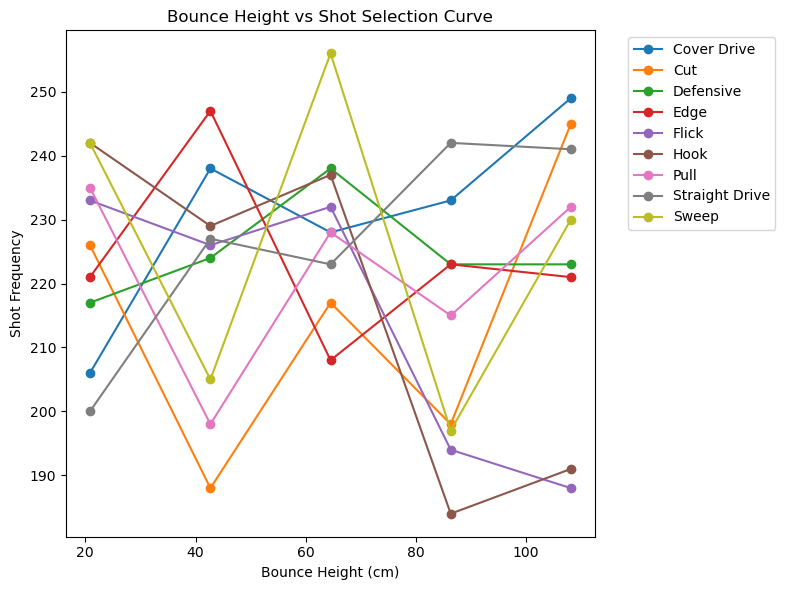

In [71]:
pivot_df = bounce_shot.copy()  
centers = [b.mid for b in pivot_df.index]
pivot_df.index = centers

plt.figure(figsize=(8,6))

for shot in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[shot], marker='o', label=shot)

plt.xlabel("Bounce Height (cm)")
plt.ylabel("Shot Frequency")
plt.title("Bounce Height vs Shot Selection Curve")

plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


With low bounce (20-30), there is a high chance to score sweep, hook, pull and flick while there is a lower chance to do a straight and cover drive.
With medium bounce (40-60), there is a high chance to score defensive, cover drive, flick and sweep
With high bounce (40-60), there is a high chance to be more defensive and play cover drive.
So, for advice, bowlers should give more bounce.

In [72]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

df2 = df.copy()


median_runs = df2['Runs Scored'].median()

df2['Good'] = ((df2['Wicket'] == 1) | 
               (df2['Runs Scored'] <= median_runs)).astype(int)


X = df2[['Bowler Type','Ball Length','Ball Line',
         'Speed (km/h)','Angle','Bounce (cm)']]

y = df2['Good']

cat_cols = ['Bowler Type','Ball Length','Ball Line']
num_cols = ['Speed (km/h)','Angle','Bounce (cm)']

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

model = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model.fit(X_train,y_train)

print("Model Accuracy:", model.score(X_test,y_test))

df2['Good_Prob'] = model.predict_proba(X)[:,1]

fig = px.scatter_3d(
    df2,
    x='Angle',
    y='Bounce (cm)',
    z='Speed (km/h)',
    color='Good_Prob',
    size='Runs Scored',
    hover_data=['Ball Length','Ball Line','Bowler Type'],
    title="Aerodynamic Prediction of Good Bowling (Probability Surface)",
)

fig.update_layout(height=800)

fig.show()

Model Accuracy: 0.558


This showed that the dots in the yellow showed greater significance in being a successful bowler with right angle and bounce but the colour changes from bright yellow to dark blue as the angle becomes positive and the bowling speed is moderate which allows players to smack the balls much easily.